In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer

In [2]:
df = pd.read_csv('../house_prices_selection.csv')
print(df.shape)
df.head()


(1460, 32)


,EVI,ZoningScore,MSZoning_RL,LotConfig_CulDSac,LandContour_HLS,LotShape_IR2,Condition1_Norm,Condition1_Feedr,LotShape_Reg,MSZoning_RM,...,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,GrLivArea,TotalBsmtSF,1stFlrSF,BsmtQual,CentralAir,Foundation
0,0.437530,0.835044,True,False,False,False,True,False,True,False,...,7,2003,2003,196.0,1710,856,856,Gd,Y,PConc
1,0.364741,0.835044,True,False,False,False,False,True,True,False,...,6,1976,1976,0.0,1262,1262,1262,Gd,Y,CBlock
2,0.411955,0.835044,True,False,False,False,True,False,False,False,...,7,2001,2002,162.0,1786,920,920,Gd,Y,PConc
3,0.394783,0.835044,True,False,False,False,True,False,False,False,...,7,1915,1970,0.0,1717,756,961,TA,Y,BrkTil
4,0.399533,0.835044,True,False,False,False,True,False,False,False,...,8,2000,2000,350.0,2198,1145,1145,Gd,Y,PConc


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EVI                1460 non-null   float64
 1   ZoningScore        1460 non-null   float64
 2   MSZoning_RL        1460 non-null   bool   
 3   LotConfig_CulDSac  1460 non-null   bool   
 4   LandContour_HLS    1460 non-null   bool   
 5   LotShape_IR2       1460 non-null   bool   
 6   Condition1_Norm    1460 non-null   bool   
 7   Condition1_Feedr   1460 non-null   bool   
 8   LotShape_Reg       1460 non-null   bool   
 9   MSZoning_RM        1460 non-null   bool   
 10  Price_per_m^2      1460 non-null   float64
 11  PDI                1460 non-null   float64
 12  SalePrice          1460 non-null   int64  
 13  LotFrontage        1201 non-null   float64
 14  LotArea            1460 non-null   int64  
 15  WoodDeckSF         1460 non-null   int64  
 16  OpenPorchSF        1460 

In [4]:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
boolean_features = df.select_dtypes(include=['bool']).columns.tolist()

print(f"Coloane numerice ({len(numerical_features)}): {numerical_features}")
print(f"\nColoane categorice ({len(categorical_features)}): {categorical_features}")   
print(f"\nColoane booleene ({len(boolean_features)}): {boolean_features}")

Coloane numerice (19): ['EVI', 'ZoningScore', 'Price_per_m^2', 'PDI', 'SalePrice', 'LotFrontage', 'LotArea', 'WoodDeckSF', 'OpenPorchSF', 'FullBath', 'GarageCars', 'GarageArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF']

Coloane categorice (5): ['KitchenQual', 'PavedDrive', 'BsmtQual', 'CentralAir', 'Foundation']

Coloane booleene (8): ['MSZoning_RL', 'LotConfig_CulDSac', 'LandContour_HLS', 'LotShape_IR2', 'Condition1_Norm', 'Condition1_Feedr', 'LotShape_Reg', 'MSZoning_RM']


In [5]:
numerical_features.remove('SalePrice') 
print(f"Coloane numerice ({len(numerical_features)}): {numerical_features}")
print(f"\nColoane categorice ({len(categorical_features)}): {categorical_features}")

Coloane numerice (18): ['EVI', 'ZoningScore', 'Price_per_m^2', 'PDI', 'LotFrontage', 'LotArea', 'WoodDeckSF', 'OpenPorchSF', 'FullBath', 'GarageCars', 'GarageArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF']

Coloane categorice (5): ['KitchenQual', 'PavedDrive', 'BsmtQual', 'CentralAir', 'Foundation']


In [6]:
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(f"\nValori lipsă în dataset:")
print(missing_df)


Valori lipsă în dataset:
         Column  Missing_Count  Percentage
13  LotFrontage            259   17.739726
29     BsmtQual             37    2.534247
25   MasVnrArea              8    0.547945


In [7]:
df_test = pd.read_csv('../data/Cornescu_Darius_selected_features.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SalePrice          1460 non-null   int64  
 1   LotFrontage        1460 non-null   float64
 2   ZoningScore        1460 non-null   float64
 3   EVI                1460 non-null   float64
 4   Price_per_m^2      1460 non-null   float64
 5   LotArea            1460 non-null   int64  
 6   PDI                1460 non-null   float64
 7   MSZoning_RL        1460 non-null   bool   
 8   LotConfig_CulDSac  1460 non-null   bool   
 9   LotShape_IR2       1460 non-null   bool   
 10  LandContour_HLS    1460 non-null   bool   
 11  Condition1_Norm    1460 non-null   bool   
 12  Condition1_Feedr   1460 non-null   bool   
 13  LotShape_Reg       1460 non-null   bool   
 14  MSZoning_RM        1460 non-null   bool   
dtypes: bool(8), float64(5), int64(2)
memory usage: 91.4 KB


In [8]:
missing_values = df_test.isnull().sum()
missing_percent = (missing_values / len(df_test)) * 100
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Percentage': missing_percent.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(f"\nValori lipsă în dataset:")
print(missing_df)


Valori lipsă în dataset:
Empty DataFrame
Columns: [Column, Missing_Count, Percentage]
Index: []


In [9]:
for cols in boolean_features:
    df[cols] = df[cols].astype(int)

numerical_features.extend(boolean_features)
print(f"Coloane numerice (inclusiv boolean) ({len(numerical_features)}): {numerical_features}")
print(f"\nColoane categorice ({len(categorical_features)}): {categorical_features}")

Coloane numerice (inclusiv boolean) (26): ['EVI', 'ZoningScore', 'Price_per_m^2', 'PDI', 'LotFrontage', 'LotArea', 'WoodDeckSF', 'OpenPorchSF', 'FullBath', 'GarageCars', 'GarageArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'MSZoning_RL', 'LotConfig_CulDSac', 'LandContour_HLS', 'LotShape_IR2', 'Condition1_Norm', 'Condition1_Feedr', 'LotShape_Reg', 'MSZoning_RM']

Coloane categorice (5): ['KitchenQual', 'PavedDrive', 'BsmtQual', 'CentralAir', 'Foundation']


In [10]:
X = df.drop('SalePrice', axis=1)
Y = df['SalePrice']
print(f"Features shape: {X.shape}")
print(f"Target shape: {Y.shape}")

Features shape: (1460, 31)
Target shape: (1460,)


In [11]:
df_clean = df.dropna()
X_clean = df_clean.drop('SalePrice', axis=1)
Y_clean = df_clean['SalePrice']
print(f"\nDataset după eliminarea valorilor lipsă: {df_clean.shape}")
print(f"Rânduri eliminate: {len(df) - len(df_clean)}")


Dataset după eliminarea valorilor lipsă: (1164, 32)
Rânduri eliminate: 296


In [12]:
numeric_features_clean = X_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features_clean = X_clean.select_dtypes(include=['object']).columns.tolist()

In [13]:
preprocessor_dropna = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_clean),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features_clean)
    ])

pipeline_dropna = Pipeline([
    ('preprocessor', preprocessor_dropna),
    ('regressor', LinearRegression())
])

X_train_dropna, X_test_dropna, Y_train_dropna, Y_test_dropna = train_test_split( X_clean, Y_clean, test_size=0.2, random_state=42)

pipeline_dropna.fit(X_train_dropna, Y_train_dropna)
Y_pred_dropna = pipeline_dropna.predict(X_test_dropna)

mae_dropna = mean_absolute_error(Y_test_dropna, Y_pred_dropna)
rmse_dropna = np.sqrt(mean_squared_error(Y_test_dropna, Y_pred_dropna))
r2_dropna = r2_score(Y_test_dropna, Y_pred_dropna)

print(f"\nREZULTATE ABORDAREA 1 (dropna):")
print(f"MAE: ${mae_dropna:,.2f}")
print(f"RMSE: ${rmse_dropna:,.2f}")
print(f"R² Score: {r2_dropna:.4f}")




REZULTATE ABORDAREA 1 (dropna):
MAE: $21,732.42
RMSE: $35,344.64
R² Score: 0.8358


In [14]:
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=7)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor_imputer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline_imputer = Pipeline([
    ('preprocessor', preprocessor_imputer),
    ('regressor', LinearRegression())
])

X_train_imputer, X_test_imputer, Y_train_imputer, Y_test_imputer = train_test_split( X, Y, test_size=0.2, random_state=42 )

pipeline_imputer.fit(X_train_imputer, Y_train_imputer)
y_pred_imputer = pipeline_imputer.predict(X_test_imputer)

mae_imputer = mean_absolute_error(Y_test_imputer, y_pred_imputer)
rmse_imputer = np.sqrt(mean_squared_error(Y_test_imputer, y_pred_imputer))
r2_imputer = r2_score(Y_test_imputer, y_pred_imputer)

print(f"\nREZULTATE ABORDAREA 2 (SimpleImputer):")
print(f"MAE: ${mae_imputer:,.2f}")
print(f"RMSE: ${rmse_imputer:,.2f}")
print(f"R² Score: {r2_imputer:.4f}")


REZULTATE ABORDAREA 2 (SimpleImputer):
MAE: $21,892.38
RMSE: $34,297.28
R² Score: 0.8466


**Rezultatele celor două abordări sunt apropiate, însă diferă în moduri relevante.** Abordarea 1 (dropna) oferă un MAE puțin mai bun, dar un RMSE mai slab și un scor R² mai mic. În schimb, Abordarea 2 (cu *KNNImputer*) are un MAE ușor mai mare, însă obține cel mai mic RMSE și cel mai ridicat R², indicând o capacitate mai bună de a explica variația datelor și o performanță globală mai stabilă.

**Per ansamblu, metoda cu imputare pare mai potrivită pentru acest set de date**, deoarece păstrează mai multe informații și conduce la un model cu performanță generală superioară.


# Next laboratory :
```
Azi continuam lucrul pe notebook-ul de data trecuta. Planul este urmatorul:
Incarcam datasetul cu toate datele.
Cream pipeline-uri folosind SimpleImputer si OneHotEncoder pentru variabilele categorice.
Comparam modelele Linear Regression, DecisionTreeRegressor si RandomForestRegressor.
Pe fiecare model vom aplica Cross Validation impreuna cu GridSearchCV.
```

In [15]:
numerical_transformer_decision_tree = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=7))
])

categorical_transformer_decision_tree = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor_decision_tree = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_decision_tree, numerical_features),
        ('cat', categorical_transformer_decision_tree, categorical_features)
    ])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
# models = {
#     'Linear Regression': {
#         'model': LinearRegression(),
#         'params': {}
#     },
#     'Decision Tree': {
#         'model': DecisionTreeRegressor(random_state=42),
#         'params': {
#             'regressor__max_depth': [5, 10, 15, 20, None],
#             'regressor__min_samples_split': [2, 5, 10, 20],
#             'regressor__min_samples_leaf': [1, 2, 4, 8],
#             'regressor__max_features': ['sqrt', 'log2', None],
#             'regressor__criterion': ['squared_error', 'friedman_mse']
#         }
#     },
#     'Random Forest': {
#         'model': RandomForestRegressor(random_state=42),
#         'params': {
#             'regressor__n_estimators': [100, 300, 500],
#             'regressor__max_depth': [10, 15, 20, None],
#             'regressor__min_samples_leaf': [1, 2, 4, 8],
#             'regressor__min_samples_split': [2, 5, 10],
#             'regressor__max_features': ['sqrt', 'log2', None],
#             'regressor__bootstrap': [True]
#         }
#     }
# }


In [17]:
# results = {}
# for model_name, configurations in models.items():
#     print(f"\nTunning model: {model_name}")

#     pripeline = Pipeline([
#         ('preprocessor', preprocessor_decision_tree),
#         ('regressor', configurations['model'])
#     ])

#     cross_validation = cross_val_score(pripeline, X_train, Y_train, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
#     print(f"\nCross-Validation MAE: ${-cross_validation.mean():,.2f} (+/- ${cross_validation.std():,.2f})")

#     if configurations['params']:
#         grid_search = GridSearchCV(pripeline, configurations['params'], cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
#         grid_search.fit(X_train, Y_train)
#         best_model = grid_search.best_estimator_
#         print(f"Best parameters: {grid_search.best_params_}")
#         best_model = grid_search.best_estimator_
#     else:
#         best_model = pripeline
#         best_model.fit(X_train, Y_train)
    
#     Y_pred = best_model.predict(X_test)
#     mae = mean_absolute_error(Y_test, Y_pred)
#     rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
#     r2 = r2_score(Y_test, Y_pred)

#     results[model_name] = {
#         'MAE': mae,
#         'RMSE': rmse,
#         'R2': r2,
#         'model': best_model
#     }
    
#     print(f"\n--- REZULTATE FINALE ---")
#     print(f"MAE: ${mae:,.2f}")
#     print(f"RMSE: ${rmse:,.2f}")
#     print(f"R² Score: {r2:.4f}")



| # | Model             | MAE       | RMSE      | R²     |
|---|-------------------|-----------|-----------|--------|
| 0 | Linear Regression | 21892.38  | 34297.28  | 0.8466 |
| 1 | Decision Tree     | 21060.28  | 32200.02  | 0.8648 |
| **2** | **Random Forest**     | **16132.14**  | **27392.48**  | **0.9022** |

## Comparație între modele

- **Random Forest** este modelul cu cea mai bună performanță:
  - Are **cel mai mic MAE (~16.1k)** → greșeală medie absolută cea mai mică în estimarea prețului.
  - Are **cel mai mic RMSE (~27.4k)** → penalizează mai puțin erorile mari, ceea ce arată o predicție mai stabilă.
  - Are **cel mai mare R² (~0.90)** → explică aproximativ 90% din variația prețului.

- **Decision Tree**:
  - Performanță **mai bună decât Linear Regression** (MAE și RMSE mai mici, R² mai mare).

- **Linear Regression**:
  - Este cel mai simplu și mai ușor de interpretat model, dar:
  - Are **MAE și RMSE mai mari** și **R² mai mic** față de modelele bazate pe arbori, ceea ce arată că nu surprinde suficient de bine relațiile neliniare din date.


# Laborator 19 noiembrie

In [18]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [34]:
models_boosting = {
    'XGBoost': {
        'model': XGBRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 300, 500],
            'regressor__max_depth': [3, 5, 6],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__subsample': [0.7, 0.8, 1.0],
            'regressor__colsample_bytree': [0.7, 0.8, 1.0]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=42),
        'params': {
            'regressor__n_estimators': [100, 300, 500],
            'regressor__max_depth': [-1, 5, 10],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__subsample': [0.7, 0.8],
            'regressor__colsample_bytree': [0.7, 0.8]
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_state=42, verbose=False, allow_writing_files=False),
        'params': {
            'regressor__iterations': [100, 300, 500],
            'regressor__depth': [3, 5, 7],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__subsample': [0.7, 0.8, 1.0]
        }
    }
}

In [35]:
numerical_transformer_catboost = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=7))
])

categorical_transformer_catboost = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor_catboost = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_catboost, numerical_features),
        ('cat', categorical_transformer_catboost, categorical_features)
    ]
)

In [36]:
results_boosting = {}

for model_name, configurations in models_boosting.items():
    print(f"Training model: {model_name}")
    
    if model_name == 'CatBoost':
        preprocessor_used = preprocessor_catboost

        configurations['model'].set_params( allow_writing_files=False, verbose=0)

        if categorical_features:
            cat_indices = list(range(len(numerical_features), len(numerical_features) + len(categorical_features)))
            configurations['model'].set_params(cat_features=cat_indices)
    else:
        preprocessor_used = preprocessor_decision_tree
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor_used),
        ('regressor', configurations['model'])
    ])
    
    cv_scores = cross_val_score(pipeline, X_train, Y_train, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    print(f"\nCross-Validation MAE: ${-cv_scores.mean():,.2f} (+/- ${cv_scores.std():,.2f})")
    
    if configurations['params']:
        print(f"\nRunning GridSearchCV with {len(configurations['params'])} parameter(s)...")
        grid_search = GridSearchCV(pipeline, configurations['params'], cv=5, n_jobs=-1,  scoring='neg_mean_absolute_error', verbose=1)
        grid_search.fit(X_train, Y_train)
        best_model = grid_search.best_estimator_
        print(f"\nBest parameters: {grid_search.best_params_}")
        print(f"Best CV MAE: ${-grid_search.best_score_:,.2f}")
    else:
        best_model = pipeline
        best_model.fit(X_train, Y_train)
    
    Y_pred = best_model.predict(X_test)
    mae = mean_absolute_error(Y_test, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    r2 = r2_score(Y_test, Y_pred)
    
    results_boosting[model_name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'CV_MAE_mean': -cv_scores.mean(),
        'CV_MAE_std': cv_scores.std(),
        'model': best_model
    }
    
    print(f"\n--- REZULTATE FINALE ---")
    print(f"MAE: ${mae:,.2f}")
    print(f"RMSE: ${rmse:,.2f}")
    print(f"R² Score: {r2:.4f}")

Training model: XGBoost

Cross-Validation MAE: $15,617.41 (+/- $1,389.79)

Running GridSearchCV with 5 parameter(s)...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Best parameters: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 500, 'regressor__subsample': 0.7}
Best CV MAE: $11,343.96

--- REZULTATE FINALE ---
MAE: $9,601.55
RMSE: $14,828.78
R² Score: 0.9713
Training model: LightGBM

Cross-Validation MAE: $13,731.99 (+/- $1,280.87)

Running GridSearchCV with 5 parameter(s)...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2769
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 38
[LightG

c:\Users\dariu\Documents\GithubRepos\house-price-prediction-integra\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Cross-Validation MAE: $11,388.74 (+/- $964.87)

Running GridSearchCV with 4 parameter(s)...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters: {'regressor__depth': 5, 'regressor__iterations': 500, 'regressor__learning_rate': 0.1, 'regressor__subsample': 0.7}
Best CV MAE: $11,115.09

--- REZULTATE FINALE ---
MAE: $9,999.26
RMSE: $16,232.77
R² Score: 0.9656


In [26]:
results_df = pd.DataFrame({
    'Model': list(results_boosting.keys()),
    'MAE': [results_boosting[model]['MAE'] for model in results_boosting.keys()],
    'RMSE': [results_boosting[model]['RMSE'] for model in results_boosting.keys()],
    'R²': [results_boosting[model]['R²'] for model in results_boosting.keys()],
    'CV MAE (mean)': [results_boosting[model]['CV_MAE_mean'] for model in results_boosting.keys()],
    'CV MAE (std)': [results_boosting[model]['CV_MAE_std'] for model in results_boosting.keys()]
})

results_df = results_df.sort_values('MAE')
results_df = results_df.reset_index(drop=True)

print("\n" + "="*100)
print("COMPARAȚIE FINALĂ - TOATE MODELELE")
print("="*100)
print(results_df.to_string(index=False))


COMPARAȚIE FINALĂ - TOATE MODELELE
   Model          MAE         RMSE       R²  CV MAE (mean)  CV MAE (std)
 XGBoost  9601.552734 14828.782283 0.971332   15617.405273   1389.792161
CatBoost  9999.264278 16232.765019 0.965646   11388.735889    964.866594
LightGBM 11630.609876 20253.782460 0.946519   13731.989383   1280.866429


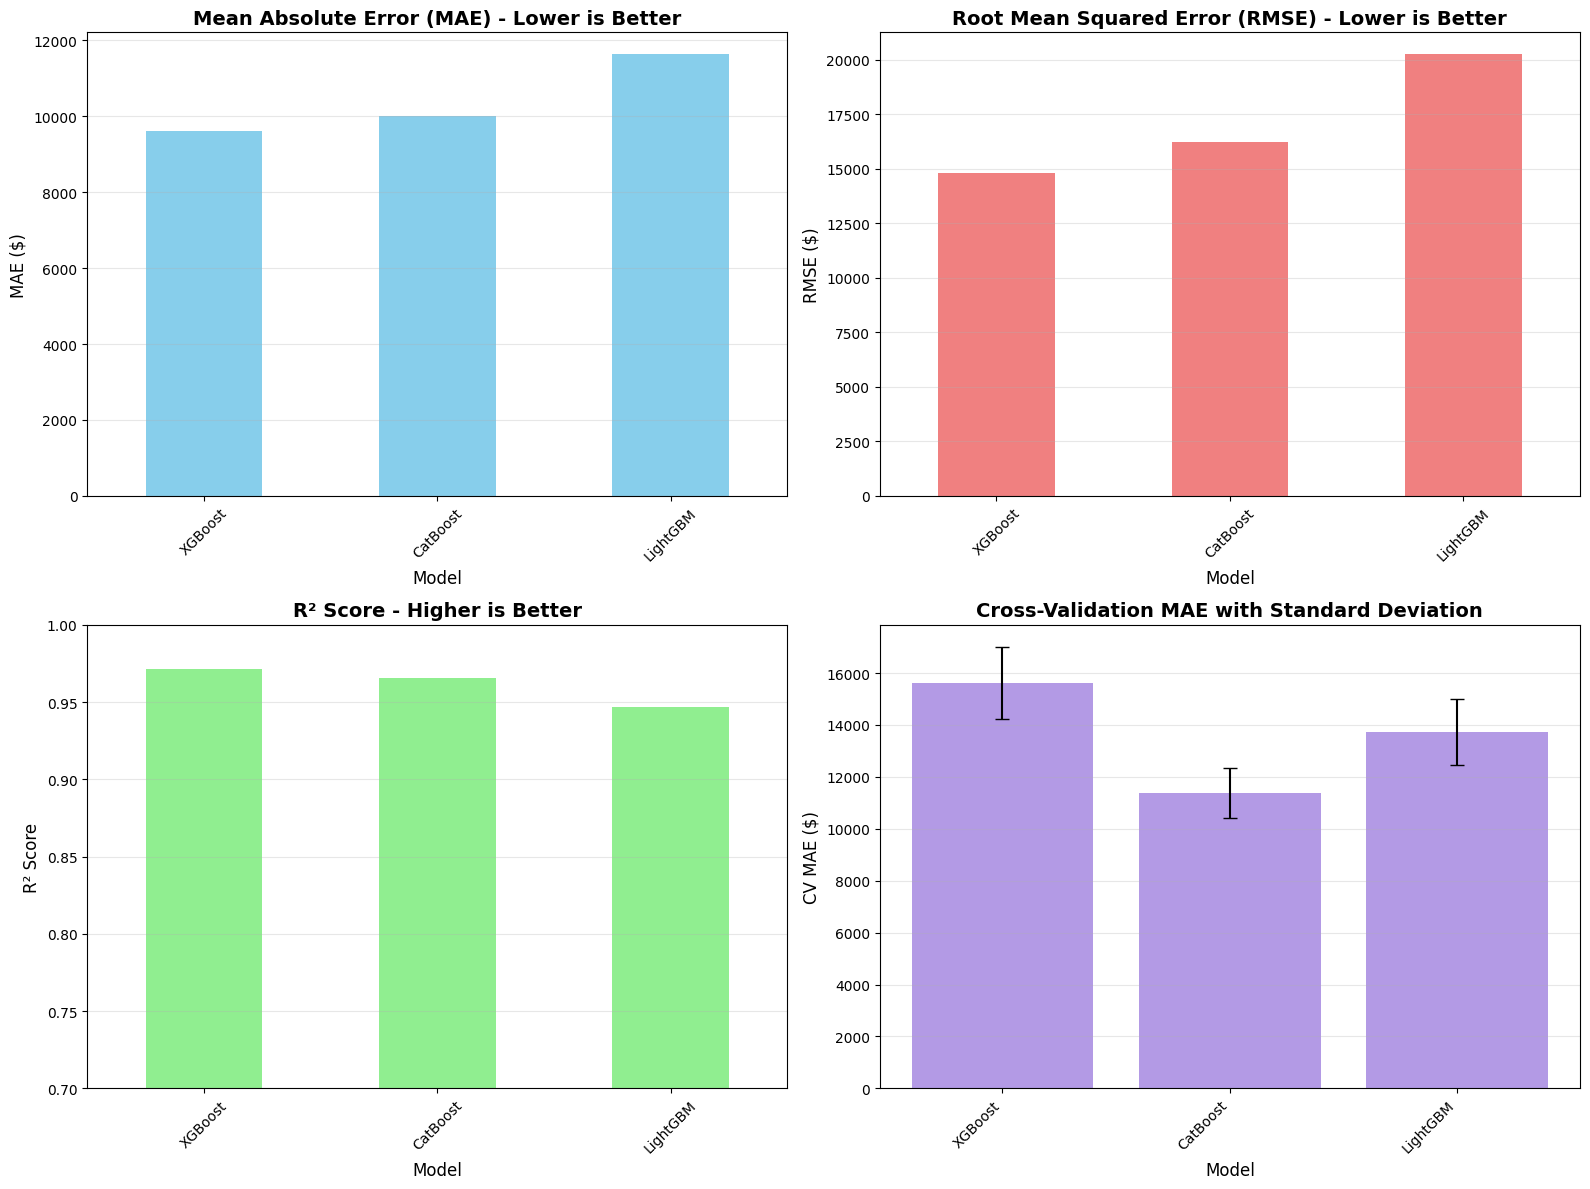

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
results_df.plot(x='Model', y='MAE', kind='bar', ax=ax1, color='skyblue')
ax1.set_title('Mean Absolute Error (MAE) - Lower is Better', fontsize=14, fontweight='bold')
ax1.set_ylabel('MAE', fontsize=12)
ax1.set_xlabel('Model', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[0, 1]
results_df.plot(x='Model', y='RMSE', kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Root Mean Squared Error (RMSE) ', fontsize=14, fontweight='bold')
ax2.set_ylabel('RMSE', fontsize=12)
ax2.set_xlabel('Model', fontsize=12)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

ax3 = axes[1, 0]
results_df.plot(x='Model', y='R²', kind='bar', ax=ax3, color='lightgreen')
ax3.set_title('R² Score - Higher is Better', fontsize=14, fontweight='bold')
ax3.set_ylabel('R² Score', fontsize=12)
ax3.set_xlabel('Model', fontsize=12)
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0.7, 1.0])

ax4 = axes[1, 1]
x_pos = np.arange(len(results_df))
ax4.bar(x_pos, results_df['CV MAE (mean)'], yerr=results_df['CV MAE (std)'], capsize=5, color='mediumpurple', alpha=0.7)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax4.set_title('Cross-Validation MAE with Standard Deviation', fontsize=14, fontweight='bold')
ax4.set_ylabel('CV MAE ($)', fontsize=12)
ax4.set_xlabel('Model', fontsize=12)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()